In [1]:
import sys 
sys.path.append('..')

import warnings
warnings.filterwarnings(
    "ignore",
    message=".*penalty=None will ignore the C and l1_ratio parameters.*",
    category=UserWarning
)

import pandas as pd

from helpers.lift import area_ratio, area_ratio_scorer, plot_lift_chart

df = pd.read_csv('../data/engineered.csv')

df.head()

,Unnamed: 0,X1,X3,X5,X6,X7,X8,X9,X10,X11,...,payment_total,payment_avg,payment_std,payment_max,payment_min,payment_growth,payment_trend,payment_zero_count,payment_all_zero,payment_low_count
0,0,20000,2,24,2,2,-1,-1,-2,-2,...,689,114.833336,281.28308,689,0,0,59.057144,5,0,6
1,1,120000,2,26,-1,2,0,0,0,2,...,5000,833.333300,752.77264,2000,0,-2000,-200.000000,2,0,2
2,2,90000,2,34,0,0,0,0,0,0,...,11018,1836.333400,1569.81540,5000,1000,-3482,-454.571440,0,0,0
3,3,50000,2,37,0,0,0,0,0,0,...,8388,1398.000000,478.05817,2019,1000,1000,227.142850,0,0,0
4,4,50000,2,57,-1,0,-1,0,0,0,...,59049,9841.500000,13786.23000,36681,679,1321,3302.314200,0,0,2


In [2]:
from sklearn.model_selection import train_test_split

X = df.drop('Y', axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*penalty=None will ignore the C and l1_ratio parameters.*",
    category=UserWarning
)

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

logistic_regression_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_regression_clf', LogisticRegression())
])

param_grid_lr = [
    # liblinear supports l1 & l2, OvR only
    {
        "logistic_regression_clf__solver": ["liblinear"],
        "logistic_regression_clf__penalty": ["l1", "l2"],
        "logistic_regression_clf__C": [0.01, 0.1, 1, 10, 100],
        "logistic_regression_clf__class_weight": [None, "balanced"],
        "logistic_regression_clf__fit_intercept": [True, False],
        "logistic_regression_clf__max_iter": [10000],
        "logistic_regression_clf__random_state": [42]
    },

    # lbfgs/newton-cg/newton-cholesky/sag => only l2 or none
    {
        "logistic_regression_clf__solver": ["lbfgs", "newton-cg", "newton-cholesky", "sag"],
        "logistic_regression_clf__penalty": ["l2", None],
        "logistic_regression_clf__C": [0.01, 0.1, 1, 10, 100],
        "logistic_regression_clf__class_weight": [None, "balanced"],
        "logistic_regression_clf__fit_intercept": [True, False],
        "logistic_regression_clf__max_iter": [10000],
        "logistic_regression_clf__random_state": [42]
    },

    # saga is the only one that supports elasticnet
    {
        "logistic_regression_clf__solver": ["saga"],
        "logistic_regression_clf__penalty": ["l1", "l2", "elasticnet", None],
        "logistic_regression_clf__C": [0.01, 0.1, 1, 10, 100],
        "logistic_regression_clf__class_weight": [None, "balanced"],
        "logistic_regression_clf__fit_intercept": [True, False],
        "logistic_regression_clf__max_iter": [10000],
        "logistic_regression_clf__l1_ratio": [0.1, 0.5, 0.9], # only used if penalty='elasticnet'
        "logistic_regression_clf__random_state": [42] 
    }
]

grid_search_lr = GridSearchCV(
    estimator=logistic_regression_pipeline,
    param_grid=param_grid_lr,
    scoring=area_ratio_scorer,
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search_lr.fit(X_train, y_train)

print("Best params:", grid_search_lr.best_params_)
print("Best CV score:", grid_search_lr.best_score_)

Fitting 5 folds for each of 440 candidates, totalling 2200 fits
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=liblinear; total time=   0.3s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=liblinear; total time=   0.3s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=liblinear; total time=   0.

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.36806e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cg; total time=   0.5s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.4s
[CV] END logistic_regression_clf__C=0.01, l

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.17899e-18): result may not be accurate.
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.4s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=lbfgs; total time=   0.1s
[CV] END logistic_regression_clf__C=0.01, logist

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=6.84997e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cg; total time=   0.3s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cg; total time=   0.3s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=0.01, logi

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=9.90829e-19): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.93387e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cg; total time=   0.3s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.64846e-20): result may not be accurate.
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.1s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   1.8s
[CV] END logistic_regression_clf__C=0.0

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.40095e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cg; total time=   0.2s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cg; total time=   0.4s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.11205e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   1.7s
[CV] END logistic_regression_clf__C=

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=6.84997e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cg; total time=   0.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   3.1s
[CV] END logistic_regression_clf__C=0.1, logistic_regression

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=9.37595e-19): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.1s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0.1,

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=6.84997e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  10.6s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cg; total time=   0.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  10.6s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__cla

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=9.37689e-19): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.93387e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cg; total time=   0.3s
[CV] END logistic_regression_clf__

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.6936e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in t

[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   3.8s
[CV] END logistic_regression_clf__C=0.1, l

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.40095e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cg; total time=   0.3s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_cl

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.70113e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  10.7s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   5.6s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   5.9s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=6.84997e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cg; total time=   0.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=1, logistic_regr

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=9.37595e-19): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   6.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   7.7s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  13.3s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.3334e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in t

[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=9.37689e-19): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  12.9s
[CV] END logistic_regression_clf__C=1, logistic_regressi

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.27146e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   4.6s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=1, logistic_

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.64846e-20): result may not be accurate.
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   4.8s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   6.3s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   4.7s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weig

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.40095e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   8.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.11205e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_cl

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=6.84997e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.1s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=9.7737e-19): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in t

[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.1s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  15.2s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.17899e-18): result may not be accurate.
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  10.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  14.0s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  13.2s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_we

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=6.84997e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cg; total time=   0.3s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=10, logist

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=9.90829e-19): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  11.8s
[CV] END logistic_regression_clf__C=10, logistic_regr

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.93387e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  22.2s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=5.17707e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_cl

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.40095e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.11205e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=9.97677e-19): result may not be accurate.
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   5.1s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  11.0s
[CV] END logistic_regression_clf__C=10, logistic_regre

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=6.84997e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.1s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=9.7737e-19): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in t

[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.1s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.17899e-18): result may not be accurate.
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  13.6s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  17.2s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   9.1s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_w

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=6.84997e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cg; total time=   0.2s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=100, lo

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=9.90829e-19): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  11.0s
[CV] END logistic_regression_clf__C=100, logistic_

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.93387e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  21.9s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=100, logi

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.64846e-20): result may not be accurate.
  warnings.warn(


[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   4.8s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  21.8s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  21.8s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=2.40095e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.2s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   4.9s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in the first place. Possible remedies are removing collinear features of X or increasing the penalization strengths.
The original Linear Algebra message was:
Ill-conditioned matrix (rcond=1.11205e-18): result may not be accurate.
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_glm/_newton_solver.py:578: LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled upon a singular or very ill-conditioned Hessian matrix at iteration 1. It will now resort to lbfgs instead.
Further options are to use another solver or to avoid such situation in 

[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=newton-cholesky; total time=   0.3s
[CV] END logistic_regress

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   7.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   6.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  13.2s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=   7.3s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  13.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.4s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.8s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time= 

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.1s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  12.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.0s
[CV] END logistic_regression_clf__C=100, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=sag; total time=  17.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.5s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.4s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.3s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regre

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.2s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.6s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_reg

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.6s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.9s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.7s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regre

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.4s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.5s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  17.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.8s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_reg

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.2s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.6s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.1s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.4s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  17.3s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_reg

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.8s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logis

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  20.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  19.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  32.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.8s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  32.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  30.8s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.6s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, l

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.1s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  31.0s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  32.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  32.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  32.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.4s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.8s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logi

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  20.2s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.8s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   7.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.7s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.7s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, lo

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  34.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  35.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  36.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.2s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.3s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.8s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_stat

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.6s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   7.9s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, lo

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.1s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.9s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.3s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, 

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.2s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.9s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.4s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.0s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42,

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.0s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.2s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.0s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.0s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   1.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.9s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.9s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, l

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   2.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  24.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.4s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.5s
[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.6s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_re

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.01, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  26.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.5s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.9s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.7s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.7s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.6s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.3s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.1s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.9s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.7s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regre

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  20.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  23.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  24.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  24.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  22.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.8s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regre

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  34.8s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   7.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  21.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  19.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  20.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  21.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   7.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.5s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.7s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.5s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regress

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  34.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   7.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.0s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.0s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.0s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.0s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logisti

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   7.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  37.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  39.7s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  39.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  39.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.0s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.7s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.5s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logis

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   8.9s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.6s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.9s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.3s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logis

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   7.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.7s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.1s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.5s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, log

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.8s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.7s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.7s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   3.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.6s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.3s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, lo

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   7.0s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   7.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.3s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.6s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__ran

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.4s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.5s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   4.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.2s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   7.5s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  10.5s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logi

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.8s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  28.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.4s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  17.6s
[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__ran

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  23.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=0.1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  21.6s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.6s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regress

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  23.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  35.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  37.9s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  23.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  36.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  19.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  37.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  27.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  39.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.5s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  22.4s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  20.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  23.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  24.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  38.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  35.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  26.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  33.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  24.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  19.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  26.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  39.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  35.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  21.7s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  19.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  34.0s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  22.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  23.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  37.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  21.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  32.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  24.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  24.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  27.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  33.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  37.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  43.9s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.9s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_cl

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.2min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.2min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  39.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  29.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  48.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  48.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  41.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  45.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  48.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regre

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  42.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  43.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.2min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  30.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  47.0s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  49.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  49.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  48.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  41.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.2min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.2min
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.1s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regre

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  42.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  43.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.0min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  30.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.2min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  17.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  20.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  49.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  47.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  49.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  49.4s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logi

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time= 1.1min


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.1s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   9.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.0s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  19.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  19.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   5.9s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.8s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logis

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.9s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  20.6s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regr

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.7s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  22.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  19.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  19.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.0s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.1s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_re

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.1s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  19.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=   6.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  20.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  19.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.4s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.5s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  19.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  17.1s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  22.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  30.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.4s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  39.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.6s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  21.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  31.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  22.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  30.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  21.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  21.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.4s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  20.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  12.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  18.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  39.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  30.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  22.8s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  27.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  16.4s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  24.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  27.7s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  22.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  11.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  22.2s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  20.4s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  13.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  19.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  30.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  39.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.0s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  22.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  21.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  22.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  14.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  22.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  20.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  22.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  40.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  23.3s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.5s
[CV] END logistic_regression_clf__C=1, logistic_regression_clf__class_weight=balanced, logistic_regression_clf__fit_intercept=False, logistic_regression_clf__l1_ratio=0.9, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regress

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  37.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  36.4s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  23.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  24.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  15.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  17.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  38.8s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  26.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  27.7s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  39.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  25.6s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  29.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.1, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  44.5s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  27.6s
[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regre

/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  31.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l2, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  33.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  30.5s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  46.6s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=l1, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  48.1s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  32.4s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  20.7s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=elasticnet, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  47.9s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  21.2s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV] END logistic_regression_clf__C=10, logistic_regression_clf__class_weight=None, logistic_regression_clf__fit_intercept=True, logistic_regression_clf__l1_ratio=0.5, logistic_regression_clf__max_iter=10000, logistic_regression_clf__penalty=None, logistic_regression_clf__random_state=42, logistic_regression_clf__solver=saga; total time=  30.3s


/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


KeyboardInterrupt: 

Best params: {'logistic_regression_clf__C': 0.01, 'logistic_regression_clf__class_weight': 'balanced', 'logistic_regression_clf__fit_intercept': True, 'logistic_regression_clf__max_iter': 10000, 'logistic_regression_clf__penalty': None, 'logistic_regression_clf__random_state': 42, 'logistic_regression_clf__solver': 'sag'}
Best CV score: 0.45235374949862095

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

optimal_lr_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('knn_clf', LogisticRegression(
                                   C=0.01,
                                   class_weight='balanced',
                                   fit_intercept=True,
                                   max_iter=10000,
                                   penalty=None,
                                   random_state=42,
                                   solver='sag'
                                ))
])

optimal_lr_pipeline.fit(X_train, y_train)



/Users/morgancooper/miniconda3/envs/HousingPredictions/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1232: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


TRAIN Error Rate: 0.3102
TRAIN Area Ratio: 0.4583
TEST Error Rate: 0.3115
TEST Area Ratio: 0.4430'


#####################################################

TRAIN Classification
              precision    recall  f1-score   support

           0       0.88      0.70      0.78     11698
           1       0.38      0.65      0.48      3284

    accuracy                           0.69     14982
   macro avg       0.63      0.68      0.63     14982
weighted avg       0.77      0.69      0.71     14982


#####################################################


TEST Classification
              precision    recall  f1-score   support

           0       0.87      0.70      0.78     11637
           1       0.38      0.64      0.48      3346

    accuracy                           0.69     14983
   macro avg       0.63      0.67      0.63     14983
weighted avg       0.76      0.69      0.71     14983



In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_train_pred_optimized = optimal_lr_pipeline.predict(X_train)
y_train_proba_optimized = optimal_lr_pipeline.predict_proba(X_train)[:, 1]

y_test_pred_optimized = optimal_lr_pipeline.predict(X_test)
y_test_proba_optimized = optimal_lr_pipeline.predict_proba(X_test)[:, 1]

train_optimized_error = 1 - accuracy_score(y_train, y_train_pred_optimized)
train_optimized_area = area_ratio(y_train, y_train_proba_optimized)

test_optimized_error = 1 - accuracy_score(y_test, y_test_pred_optimized)
test_optimized_area = area_ratio(y_test, y_test_proba_optimized)

In [ ]:
print(f'TRAIN: Error Rate {train_optimized_error:.4f}\n')
print(f'TRAIN: Area Ratio {train_optimized_area:.4f}\n')
print("TRAIN: Classification Report")
print(classification_report(y_train, y_train_pred_optimized, digits=4, zero_division=0))

In [ ]:
print(f'TEST: Error Rate {test_optimized_error:.4f}\n')
print(f'TEST: Area Ratio {test_optimized_area:.4f}\n')
print("TEST: Classification Report")
print(classification_report(y_test, y_test_pred_optimized, digits=4, zero_division=0))

In [ ]:
import numpy as np

# Sort by highest predicted risk
sorted_idx = np.argsort(-y_test_proba_optimized)  # descending order
y_true_sorted = y_test.iloc[sorted_idx].reset_index(drop=True)  # sorted ground truth


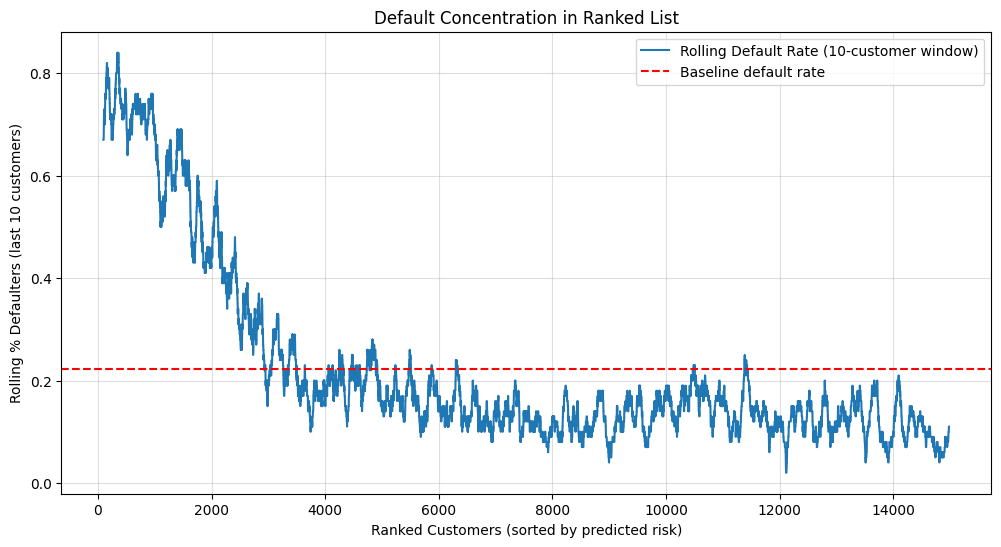

In [ ]:
import matplotlib.pyplot as plt

window_size = 800  # rolling over 10 customers
rolling_default_rate = y_true_sorted.rolling(window=window_size).mean()

plt.figure(figsize=(12, 6))

plt.plot(
    rolling_default_rate.values,
    label="Rolling Default Rate (10-customer window)"
)

# Baseline average default rate in test set
plt.axhline(y=y_test.mean(), color="red", linestyle="--", label="Baseline default rate")

plt.xlabel("Ranked Customers (sorted by predicted risk)")
plt.ylabel("Rolling % Defaulters (last 10 customers)")
plt.title("Default Concentration in Ranked List")
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [15]:
import pandas as pd
import numpy as np

# Total number of customers
n = len(y_true_sorted)

# Total defaults
total_defaults = y_true_sorted.sum()

decile_results = []

# For each decile (10%, 20%, ..., 100%)
for d in range(5, 110, 5):
    cutoff = int((d/100) * n)  # number of customers in top d%
    captured_defaults = y_true_sorted.iloc[:cutoff].sum()
    captured_pct = (captured_defaults / total_defaults) * 100
    decile_results.append({"Top % Population": f"Top {d}%", 
                           "Defaults Captured (%)": round(captured_pct, 2)})

# Create table
decile_df = pd.DataFrame(decile_results)
print(decile_df)


   Top % Population  Defaults Captured (%)
0            Top 5%                  16.29
1           Top 10%                  30.54
2           Top 15%                  41.39
3           Top 20%                  48.54
4           Top 25%                  53.38
5           Top 30%                  57.68
6           Top 35%                  62.01
7           Top 40%                  65.63
8           Top 45%                  68.89
9           Top 50%                  71.85
10          Top 55%                  74.45
11          Top 60%                  76.93
12          Top 65%                  79.71
13          Top 70%                  83.38
14          Top 75%                  86.64
15          Top 80%                  89.69
16          Top 85%                  92.35
17          Top 90%                  95.25
18          Top 95%                  97.85
19         Top 100%                 100.00
20         Top 105%                 100.00


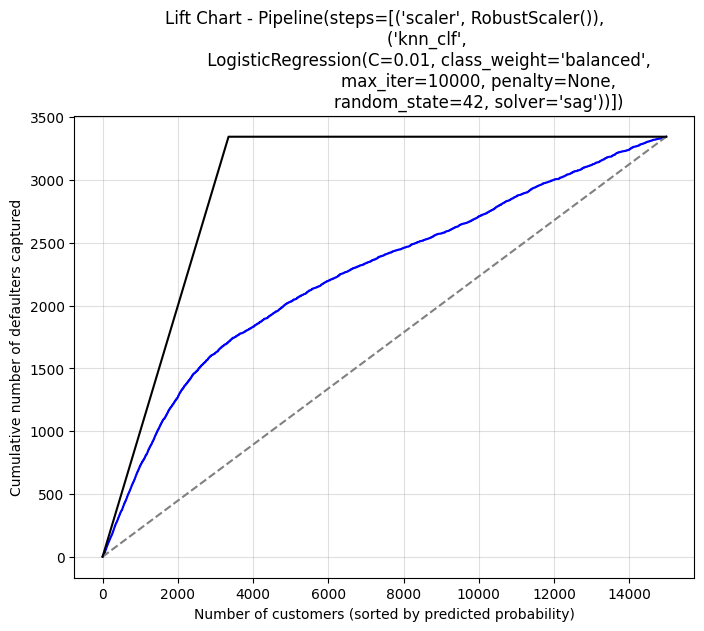

In [ ]:
plot_lift_chart(y_test, y_test_proba_optimized, optimal_lr_pipeline)